In [26]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sortedcontainers import SortedList
from datetime import datetime
# Note: You can't use SortedDict because the key is distance
# if 2 close points are the same distance away, one will be overwritten

### KNN with MNIST

In [13]:
def get_data(limit=None):
    print("Reading in and transforming data...")
    with zipfile.ZipFile("mnist_train.csv.zip") as thezip:
        thezip.extractall()

    df = pd.read_csv("mnist_train.csv")
    print(df.head())
    print(df.shape)
    data = df.to_numpy()
    np.random.shuffle(data)
    X = data[:, 1:] / 255.0 # data is from 0...255
    Y = data[:, 0]
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

In [17]:
class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X):
        y = np.zeros(len(X))
        for i, x in enumerate(X):
            sl = SortedList()
            for j, xt in enumerate(self.X):
                diff = x - xt
                d = diff.dot(diff)
                if len(sl) < self.k:
                    sl.add((d, self.y[j]))
                else:
                    if d < sl[-1][0]:
                        del sl[-1]
                        sl.add((d, self.y[j]))

            votes = {}
            for _, v in sl:
                votes[v] = votes.get(v, 0) + 1
            max_votes = 0
            max_votes_class = -1
            for v, count in votes.items():
                if count > max_votes:
                    max_votes = count
                    max_votes_class = v
            y[i] = max_votes_class
        return y

    def score(self, X, Y):
      P = self.predict(X)
      return np.mean(P == Y)


In [18]:
X, Y = get_data(2000)
Ntrain = 1000
Xtrain, Ytrain = X[:Ntrain], Y[:Ntrain]
Xtest, Ytest = X[Ntrain:], Y[Ntrain:]
for k in (1, 2, 3 ,4, 5):
    knn = KNN(k)
    t0 = datetime.now()
    knn.fit(Xtrain, Ytrain)
    print("Training time", datetime.now() - t0)

    t0 = datetime.now()
    print("Training accuracy:", knn.score(Xtrain, Ytrain))
    print("Time to compute train accuracy", datetime.now() - t0, "Train size:", len(Ytrain))

    t0 = datetime.now()
    print("Test accuracy:", knn.score(Xtest, Ytest))
    print("Time to compute test accuracy", datetime.now() - t0, "Test size:", len(Ytest))

Reading in and transforming data...
   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]
(60000, 785)
Training time 0:00:00.000010
Training accuracy: 1.0
Time to compute train accuracy 0:00:06.980675 Train size: 

In [27]:
def get_data_fail():
    width = 8
    height = 8
    N = width * height
    X = np.zeros((N, 2))
    Y = np.zeros(N)
    n = 0
    start_t = 0
    for i in range(width):
        t = start_t
        for j in range(height):
            X[n] = [i, j]
            Y[n] = t
            n += 1
            t = (t + 1) % 2
        start_t = (start_t + 1) % 2
    return X, Y

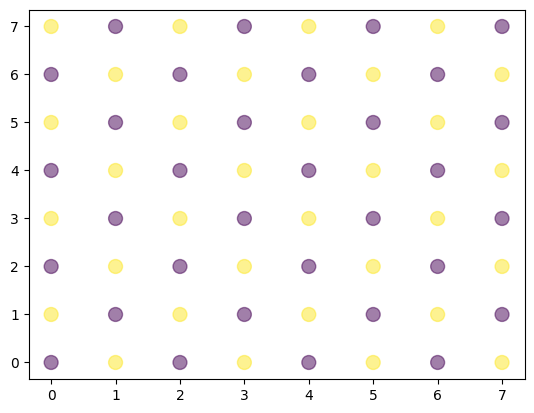

Train accuracy: 0.0


In [28]:
X, Y = get_data_fail()
plt.scatter(X[:, 0], X[:, 1], s=100, c=Y, alpha=0.5)
plt.show()

model = KNN(3)
model.fit(X, Y)
print("Train accuracy:", model.score(X, Y))

### KNN with XOR Problem

In [29]:
def get_xor():
    X = np.zeros((200, 2))
    X[:50] = np.random.random((50, 2)) / 2 + 0.5 # (0.5-1, 0.5-1)
    X[50:100] = np.random.random((50, 2)) / 2 # (0-0.5, 0-0.5)
    X[100:150] = np.random.random((50, 2)) / 2 + np.array([[0, 0.5]]) # (0-0.5, 0.5-1)
    X[150:] = np.random.random((50, 2)) / 2 + np.array([[0.5, 0]])
    Y = np.array([0]*100 + [1]*100)
    return X, Y

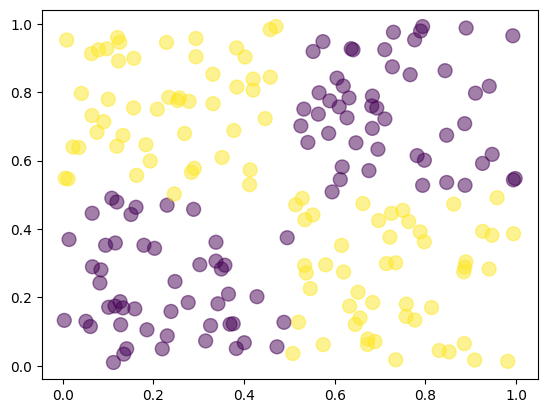

Accuracy: 0.98


In [30]:
X, Y = get_xor()
plt.scatter(X[:,0], X[:, 1], s=100, c=Y, alpha=0.5)
plt.show()

model = KNN(3)
model.fit(X, Y)
print("Accuracy:", model.score(X, Y))

### KNN with Donut Problem

In [31]:
def get_donut():
    N = 200
    R_inner = 5
    R_outer = 10

    # distance from origin is radius + random normal
    # angle theta is uniformly distributed between (0, 2pi)

    R1 = np.random.random(N//2) + R_inner
    theta = 2*np.pi*np.random.random(N//2)
    X_inner = np.concatenate([[R1*np.cos(theta)], [R1*np.sin(theta)]]).T

    R2 = np.random.random(N//2) + R_outer
    theta = 2*np.pi*np.random.random(N//2)
    X_outer = np.concatenate([[R2*np.cos(theta)], [R2*np.sin(theta)]]).T

    X = np.concatenate([X_inner, X_outer])
    Y = np.array([0]*(N//2) + [1]*(N//2))

    return X, Y


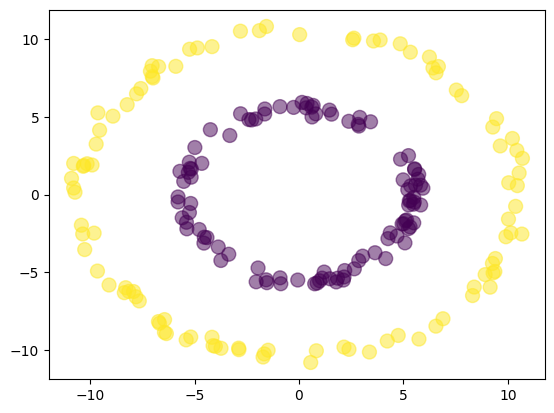

Accuracy: 1.0


In [32]:
X, Y = get_donut()
plt.scatter(X[:, 0], X[:, 1], s=100, c=Y, alpha=0.5)
plt.show()

model = KNN(3)
model.fit(X, Y)
print("Accuracy:", model.score(X, Y))